<a href="https://colab.research.google.com/github/Kori04/CSC445Final/blob/main/chap14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The Prisoner's Dilemma is a game theory problem which analyzes what people will do when presented with the choice to perform an act in secret which can get them larger payoffs if the other player(s) don't do the same thing. In the version the game gets its name from, two prisoners are presented a choice, they can either snitch or not snitch. If both choose to not snitch they will each get an equally long sentence of four years. If one chooses to snitch and the other doesn't the one who snitches will get one year and the one who didn't will get 6 years. However, if they both choose to snitch they will each get 5 years. So, what is the optimal choice? That is what this will explore looking at both long term and short terms games of the prisoner's dilemma.

The way we simulate this is by utilizing a tournament style to determine which Prisoner's Dilemma strategies come out on top after playing for a length of chosen time. We do this by killing off the weakest strategies and slightly changing strategies that did well to figure out the best over time.  We analyze this overtime evolution using 5 data sets.


*   Mean Fitness - This is the average score of all agents over time
*   Niceness - Average number of Cs in agents across all agents
*   Opening - Average number of agents who started by cooperating
*   Retaliation - Difference between number of agents who when snitched on, retaliate on the next step and who cooperate
*   Forgiving - Average number of agents who forgive defection while the defection is still in memory

These five data points allow us to closely view what changes in agents over time and what types of strategies will come out on top.

(Explain Agent Breakdown)

# Primary Writeup

This should include the Set-Up Code and Simulation itself (including a pre determined)

Talk about what the Cs and Ds do





# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [ ]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate

# I set the random seed so the notebook
# produces the same results every time.
np.random.seed(17)

--2024-12-02 18:32:40--  https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.58K  --.-KB/s    in 0s      

2024-12-02 18:32:40 (46.7 MB/s) - ‘utils.py’ saved [2645/2645]



### Previous code

From the Chapter 11 notebook, we will reuse `Simulation` and `Instrument`.

In [ ]:
class Simulation:

    def __init__(self, fit_land, agents):
        """Create the simulation:

        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []

    def add_instrument(self, instrument):
        """Adds an instrument to the list.

        instrument: Instrument object
        """
        self.instruments.append(instrument)

    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)

    def run(self, num_steps=500):
        """Run the given number of steps.

        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()

        for _ in range(num_steps):
            self.step()

    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()

        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)

        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()

    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)

    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]

    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)

    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.

        ps: probability of survival for each agent

        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.

        n: number of choices
        weights: array of weights

        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [ ]:
class Instrument:
    """Computes a metric at each timestep."""

    def __init__(self):
        self.metrics = []

    def update(self, sim):
        """Compute the current metric.

        Appends to self.metrics.

        sim: Simulation object
        """
        # child classes should implement this method
        pass

    def plot(self, **options):
        plt.plot(self.metrics, **options)

In [ ]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean fitness'

    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

### PD Agent

The genome of a Prisoner's Dilemma-playing agent is a map from the previous choices of the opponent to the agent's next choice.

In [ ]:
class Agent:

    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]

    def __init__(self, values, fitness=np.nan):
        """Initialize the agent.

        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness

    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0

    def past_responses(self, num=2):
        """Select the given number of most recent responses.

        num: integer number of responses

        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])

    def respond(self, other):
        """Choose a response based on the opponent's recent responses.

        other: Agent

        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp

    def append(self, resp, pay):
        """Update based on the last response and payoff.

        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay

    def copy(self, prob_mutate=0.05):
        """Make a copy of this agent.
        """
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)

    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.

        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

### Special Agents

Here's the genome for "always cooperate"

In [ ]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

And for "always defect"

In [ ]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

And for "tit for tat"

In [ ]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

And For No Forgiveness #Added

In [ ]:
nf = Agent('CCDCDDD')
nf.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

And For "Backstabbing" #Added

In [ ]:
back = Agent('CDCDCDC')
back.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

In [ ]:
StartDef = Agent("DCCCCCC")
StartDef.responses

{(None, None): 'D',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

The `copy` method has some probability of generating a mutation (in this example, `values` is initially a string; after mutation, it's a NumPy array of letters).

In [ ]:
np.random.seed(17)
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
['D', 'C', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'C', 'D', 'D', 'D', 'D']


In [ ]:
np.sum([all_d.copy().values != all_d.values for i in range(1000)])

57

### The Tournament

`Tournament` encapsulates the rules for the tournament.

In [ ]:
class Tournament:

    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}

    num_rounds = 6

    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.

        agent1: Agent
        agent2: Agent

        returns: tuple of agent1's score, agent2's score
        """
        agent1.reset()
        agent2.reset()

        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]

            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)

        return agent1.score, agent2.score

    def melee(self, agents, randomize=True):
        """Play each agent against two others.

        Assigns the average score from the two games to agent.fitness

        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)

        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n

        totals = np.zeros(n)

        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2

        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / 2

We can test `Tournament` with a few known scenarios.

In [ ]:
tour = Tournament()
tour.play(all_d, all_c)

(30, 0)

In [ ]:
tour.play(all_d, tft)

(10, 5)

In [ ]:
tour.play(tft, all_c)

(18, 18)

And then test `melee` with a list of three agents.

In [ ]:
agents = [all_c, all_d, tft]
agents

In [ ]:
tour.melee(agents)

In this population, "always defect" does best.

In [ ]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 1.5
DDDDDDD 3.3333333333333335
CCDCDCD 1.9166666666666667


### Round Robin Playoffs (ADDED)


In [ ]:
class PairwiseRoundRobinTournament:
    def __init__(self, payoffs, num_rounds=6):
        """
        Initialize the Pairwise Round-Robin Tournament.
        payoffs: dict
            Payoff matrix for the Prisoner's Dilemma.
        num_rounds: int
            Number of rounds for each pair.
        """
        self.payoffs = payoffs
        self.num_rounds = num_rounds
    def play(self, agent1, agent2):
        """
        Play a sequence of iterated Prisoner's Dilemma rounds between two agents.
        agent1, agent2: Agent objects
        Returns:
            Tuple of scores (agent1_score, agent2_score).
        """
        agent1.reset()
        agent2.reset()
        for _ in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)
            pay1, pay2 = self.payoffs[resp1, resp2]
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
        return agent1.score, agent2.score
    def round_robin(self, agents):
        """
        Conduct a full pairwise round-robin tournament.
        agents: list of Agent objects
        Updates agents' fitness values based on their average scores.
        """
        n = len(agents)
        totals = np.zeros(n)
        for i in range(n):
            for j in range(i + 1, n):
                print(f"Agent {i} ({agents[i].values}) vs Agent {j} ({agents[j].values})")
                score1, score2 = self.play(agents[i], agents[j])
                totals[i] += score1
                totals[j] += score2
        for i in range(n):
            agents[i].fitness = totals[i] / (n - 1) / self.num_rounds   # Average score per agent

In [ ]:
class PDSimulationWithRoundRobin(PDSimulation):
    def __init__(self, tournament, agents):
        super().__init__(tournament, agents)
    def step(self):
        """
        Run one step of the simulation.
        """
        # Run the full pairwise round-robin tournament
        self.tournament.round_robin(self.agents)
        Simulation.step(self)

In [ ]:
payoffs = {('C', 'C'): (3, 3),
           ('C', 'D'): (0, 5),
           ('D', 'C'): (5, 0),
           ('D', 'D'): (1, 1)}
tour = PairwiseRoundRobinTournament(payoffs)
tour.play(all_d, all_c)

(30, 0)

In [ ]:
agents = [all_c, all_d, tft, back, nf, StartDef]

tour.round_robin(agents)

Agent 0 (CCCCCCC) vs Agent 1 (DDDDDDD)
Agent 0 (CCCCCCC) vs Agent 2 (CCDCDCD)
Agent 0 (CCCCCCC) vs Agent 3 (CDCDCDC)
Agent 0 (CCCCCCC) vs Agent 4 (CCDCDDD)
Agent 0 (CCCCCCC) vs Agent 5 (DCCCCCC)
Agent 1 (DDDDDDD) vs Agent 2 (CCDCDCD)
Agent 1 (DDDDDDD) vs Agent 3 (CDCDCDC)
Agent 1 (DDDDDDD) vs Agent 4 (CCDCDDD)
Agent 1 (DDDDDDD) vs Agent 5 (DCCCCCC)
Agent 2 (CCDCDCD) vs Agent 3 (CDCDCDC)
Agent 2 (CCDCDCD) vs Agent 4 (CCDCDDD)
Agent 2 (CCDCDCD) vs Agent 5 (DCCCCCC)
Agent 3 (CDCDCDC) vs Agent 4 (CCDCDDD)
Agent 3 (CDCDCDC) vs Agent 5 (DCCCCCC)
Agent 4 (CCDCDDD) vs Agent 5 (DCCCCCC)


In [ ]:
for agent in agents:
  print(agent.values, agent.fitness)

CCCCCCC 1.8
DDDDDDD 3.533333333333333
CCDCDCD 2.3333333333333335
CDCDCDC 2.6666666666666665
CCDCDDD 2.566666666666667
DCCCCCC 2.0


### Probability of survival

We need a function to map from points per round (0 to 5) to probability of survival (0 to 1).  I'll use a logistic curve.

In [ ]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.

    A: controls the lower bound
    B: controls the steepness of the transition
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition

    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [ ]:
def prob_survive(scores):
    """Probability of survival, based on fitness.

    scores: sequence of scores, 0-60

    returns: probability
    """
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)

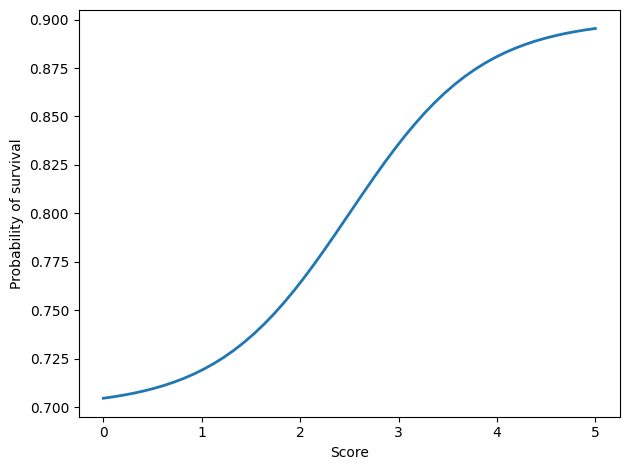

In [ ]:
survive = 0.5
scores = np.linspace(0, 5)
probs = prob_survive(scores)
plt.plot(scores, probs)
decorate(xlabel='Score', ylabel='Probability of survival')

### The simulator

The biggest change in the simulator is in `step`, which runs `melee` to determine the fitness of each agent, and `prob_survive` to map from fitness to probability of surviving.

In [ ]:
class PDSimulation(Simulation):

    def __init__(self, tournament, agents):
        """Create the simulation:

        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        self.survive = survive

    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        Simulation.step(self)

    def choose_dead(self, fits):
        """Choose which agents die in the next timestep.

        fits: fitness of each agent

        returns: indices of the chosen ones
        """
        ps = prob_survive(fits)
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

We might want to start with random agents.

In [ ]:
def make_random_agents(n):
    """Make agents with random genotype.

    n: number of agents

    returns: sequence of agents
    """
    agents = [Agent(np.random.choice(['C', 'D'], size=7))
              for _ in range(n)]
    return agents

Or with all identical agents.

In [ ]:
def make_identical_agents(n, values):
    """Make agents with the given genotype.

    n: number of agents
    values: sequence of 'C' and 'D'

    returns: sequence of agents
    """
    agents = [Agent(values) for _ in range(n)]
    return agents

Here are the instruments to compute various metrics.

`Niceness` is the average number of `C` across the genotypes in the population.

In [ ]:
class Niceness(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'

    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Opening` is the fraction of agents that cooperate in the first round.

In [ ]:
class Opening(Instrument):
    """Fraction of agents that cooperate on the first round."""
    label = 'Opening'

    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

`Retaliating` is the difference between (1) the fraction of agents that defect after the opponent defects and (2) the fraction of agents that defect after the opponent cooperates.

In [ ]:
class Retaliating(Instrument):
    """Tendency to defect after opponent defects."""
    label = 'Retaliating'

    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

Forgiving is the difference between the number of agents that cooperate after DC minus the number that cooperate after CD.

In [ ]:
class Forgiving(Instrument):
    """Tendency to cooperate if opponent cooperates after defecting."""
    label = 'Forgiving'

    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

Here's another metric intended to measure forgiveness.

In [ ]:
class Forgiving2(Instrument):
    """Ability to cooperate after the first two rounds."""
    label = 'Forgiving2'

    def update(self, sim):
        after_two = np.array([agent.values[3:] for agent in sim.agents])
        metric = np.mean(np.any(after_two=='C', axis=1))
        self.metrics.append(metric)

### Results

Here's a simulation that runs a chosen amount of a chosen agent (or random).


In [ ]:
tour = Tournament()

# User Input
agent = input("Input your 7 letter character string or 'random' for a random group:")
number = int(input("Input your number of agents:"))
steps = int(input("Enter the number of steps you want the sim to run for:"))

#Makes Agents
if agent == "random":
  make_random_agents(number)
else:
  agents = make_identical_agents(number, list(agent))

#Starts Simulation
sim = PDSimulation(tour, agents)

#Adds Trackers
sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving())

Input your 7 letter character string or 'random' for a random group:CDCDCDC
Input your number of agents:100
Enter the number of steps you want the sim to run for:500


Run the simulation.  If you get a warning about `Mean of empty slice`, that's ok.

In [ ]:
#Runs simulations with a seed
np.random.seed(17)
sim.run(500)

<ipython-input-4-682d1ebff568>:6: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(sim.get_fitnesses())


And let's look at some results.

In [ ]:
def plot_result(index, **options):
    """Plots the results of the indicated instrument.

    index: integer
    """
    sim.plot(index, **options)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    decorate(xlabel='Time steps',
                     ylabel=instrument.label)

nan


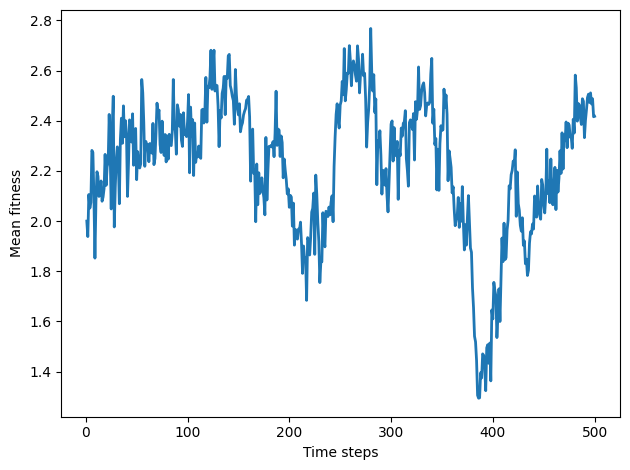

In [ ]:
#Displays Mean Fitness
plot_result(0, color='C0')
plt.show('figs/chap12-1')

nan


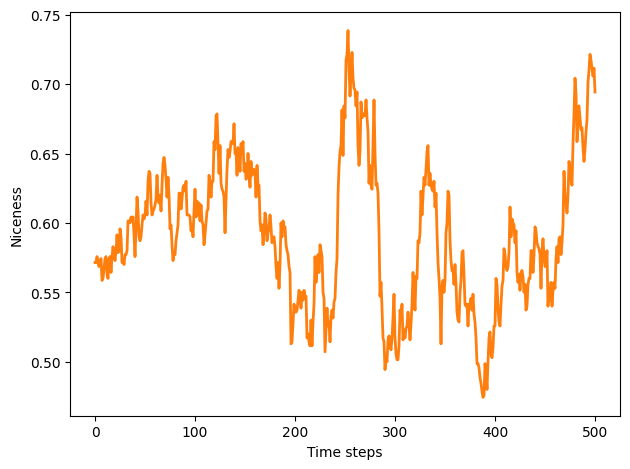

In [ ]:
#Shows Niceness (Average number of Cooperators across all agents)
plot_result(1, color='C1')

The results are similar for the opening move: the fraction of agents who start out cooperating is generally more than half, with a long-range mean above 0.6.  This fraction varies widely in time.

nan


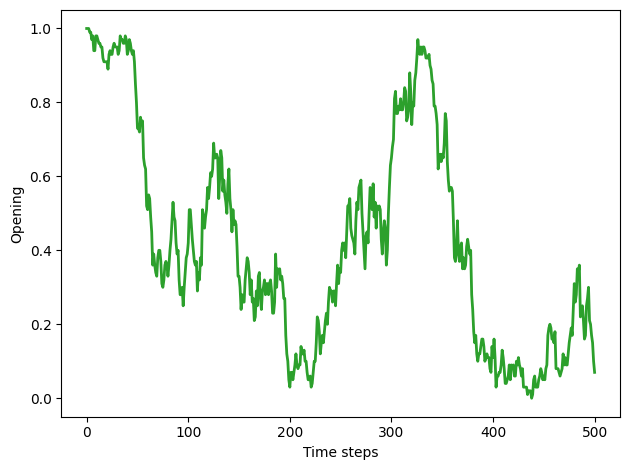

In [ ]:
#Shows Opening (Agents who started with cooperation)
plot_result(2, color='C2')

nan


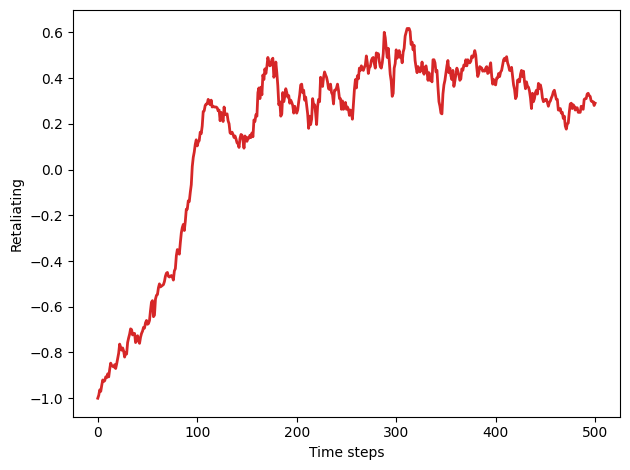

In [ ]:
#Shows Retaliation (Difference between agents who defect after defection and cooperate after defection)
plot_result(3, color='C3')

nan


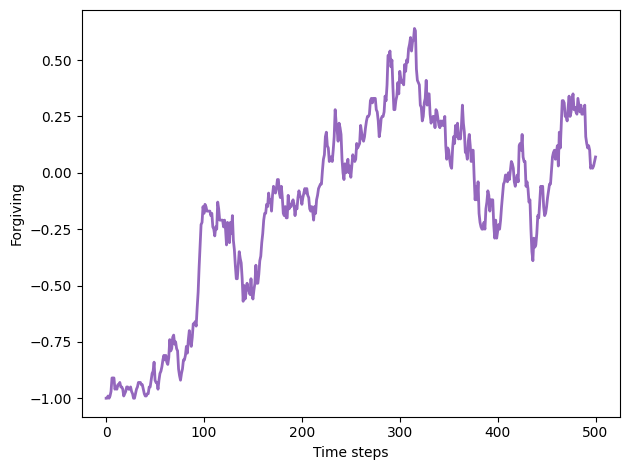

In [ ]:
#Shows average amount of agents who forgive a round or two after defection
plot_result(4, color='C4')

The following cells explore the composition of the final population.  But because the distribution of agents varies so much over time, the details of a single timestep might not mean much.

Here are the final genomes:

In [ ]:
from pandas import Series

responses = [''.join(agent.values) for agent in sim.agents]
Series(responses).value_counts()

,count
DCDCCCC,49
DCCCCCC,15
DCDCCCD,11
DCDCDCC,4
CCCCCCC,4
DDDCCCD,4
DDDCCCC,4
DCDDCCC,3
DDDDDCC,2
CCDCCCD,2


# Conclusion/Discussion

Move code for self input here


## References
